In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost
from xgboost import XGBClassifier, XGBRegressor
# from xgboost import plot_importance # Features Importance 시각화
from sklearn.metrics import roc_auc_score
import hyperopt as hopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import user_functions as uf


from matplotlib import rc


rc('font', family='NanumGothic.ttf')
# .py import 상하위폴더
# https://brownbears.tistory.com/296


# import matplotlib.font_manager as fm
# fm.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
# load
train_datasets = pd.read_csv("../pre_data/[no_up]train_datasets(log_scal).csv",
                             index_col=0)

# Label 만들기
train_target_ds = train_datasets["TARGET"]
train_target_ds = train_target_ds.astype("int32")

# TARGET feature 삭제
train_datasets.drop(columns="TARGET", inplace=True)

X_train , X_test , y_train , y_test = \
    train_test_split(train_datasets, 
                     train_target_ds, 
                     test_size=0.2, 
                     random_state=2021,
                     stratify=train_target_ds
                    )

# Valid
X_train_v, X_valid, y_train_v, y_valid = \
    train_test_split(X_train, 
                     y_train, 
                     test_size=0.25, 
                     random_state=2021,
                     stratify=y_train
                    )

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred)    # 정확도
    precision = precision_score(y_test, pred)  # 정밀도
    recall = recall_score(y_test, pred)        # 재현율
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('정확도 : {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f},\
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [25]:
# xgb_r_d = XGBRegressor(n_estimators=1000,
#                      objective="binary:logitraw", 
# #                         "binary:logistic", 7574
# #                        "reg:logistic", 7574
#                      use_label_encoder=False,
#                      tree_method="gpu_hist",
#                      booster="gbtree" # 7576
#                     )

# xgb_r_d.fit(X_train_v, y_train_v,
#         eval_metric="auc", 
#         early_stopping_rounds=300,
#         eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
#         verbose=100, # 10개 단위로 출력
#        )

# pred = xgb_r_d.predict(X_test)
# # pred_p = pd.DataFrame(xgb_r_d.predict_proba(X_test))[1]
# print("train best     score:", format(xgb_r_d.best_score, ".4f"))
# print("train best iteration:", format(xgb_r_d.best_iteration, ".3f"))
# print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
# # print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))

# get_clf_eval(y_test, pred)

In [28]:
# 기본 모델
xgb_c_b = XGBClassifier(n_estimators=1000,
                        use_label_encoder=False,
                        tree_method="gpu_hist",
                       )

xgb_c_b.fit(X_train_v, y_train_v,
            eval_metric="auc", 
            early_stopping_rounds=300,
            eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
            verbose=100
           )
pred = xgb_c_b.predict(X_test)
pred_p = pd.DataFrame(xgb_c_b.predict_proba(X_test))[1]
print("train best     score:", format(xgb_c_b.best_score, ".4f"))
print("train best iteration:", format(xgb_c_b.best_iteration, ".3f"))
# print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)

[0]	validation_0-auc:0.71462	validation_1-auc:0.71729	validation_2-auc:0.70658
[100]	validation_0-auc:0.84765	validation_1-auc:0.87878	validation_2-auc:0.75356
[200]	validation_0-auc:0.88559	validation_1-auc:0.93107	validation_2-auc:0.74591
[300]	validation_0-auc:0.90908	validation_1-auc:0.96263	validation_2-auc:0.74059
[348]	validation_0-auc:0.91636	validation_1-auc:0.97235	validation_2-auc:0.73813
train best     score: 0.7565
train best iteration: 48.000
@test  roc_auc_score: 0.5146
@test  roc_auc_score: 0.7574
오차 행렬
[[55705   171]
 [ 4735   158]]
정확도 : 0.9193, 정밀도: 0.4802, 재현율 : 0.0323,    F1 : 0.0605, AUC:0.7574


# 하이퍼파라미터 튜닝(RMSE)
---

In [7]:
from sklearn.metrics import mean_squared_error

# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
object_f = ["binary:logitraw", "reg:logistic", "binary:logistic"]
# "multi:softmax", "reg:squarederror", "rank:pairwise", "rank:ndcg", "rank:map"
booster_c = ["gbtree"]


space = {"n_estimators":hopt.hp.choice("n_estimators", [100]),
         "objective": hopt.hp.choice("objective", object_f),
         "learning_rate": hopt.hp.quniform("learning_rate", 0.01, 0.2, 0.03),
#          "max_depth": hopt.hp.choice("max_depth", [-1]),
#          "min_child_weight": hopt.hp.quniform("min_child_weight", 5, 21, 4),
         "colsample_bytree": hopt.hp.quniform("colsample_bytree", 0.2, 1, 0.2),
         "subsample": hopt.hp.quniform("subsample", 0.2, 1, 0.2),
         "reg_lambda": hopt.hp.choice("reg_lambda", reg_candidate),
         "reg_alpha": hopt.hp.choice("reg_alpha", reg_candidate),
         "scale_pos_weight": hopt.hp.quniform("scale_pos_weight", 1, 9, 2),
         "base_score": hopt.hp.quniform("base_score", 0.5, 0.8, 0.1),
         "booster": hopt.hp.choice("booster", booster_c)
        }

def hyper_param_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          objective=space["objective"],
                          learning_rate=float(space["learning_rate"]),
#                           max_depth=int(space["max_depth"]), 
#                           min_child_weight=int(space["min_child_weight"]),
                          colsample_bytree=float(space["colsample_bytree"]),
                          subsample=float(space["subsample"]),
                          reg_lambda=float(space["reg_lambda"]),
                          reg_alpha=float(space["reg_alpha"]),
                          scale_pos_weight=space["scale_pos_weight"],
                          base_score=float(space["base_score"]),
                          tree_method="gpu_hist",
                          booster=space["booster"]
                         )

    model.fit(X_train, y_train,
            eval_metric="auc", 
            early_stopping_rounds=50,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=50, # 10개 단위로 출력
            )
    
    print("="*50)
    print(model)
    print("train best     score:", format(model.best_score, ".4f"))
    print("test   roc_auc_score:", format(roc_auc_score(y_test, model.predict(X_test)), ".4f"))
    print(hopt.STATUS_OK)
    print("="*50)
    
    def RMSE(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    pred = model.predict(X_test)
    rmse= RMSE(y_test, pred)
    
    return {"loss": rmse,
            "status": hopt.STATUS_OK,
            "model": model
           }


trials = hopt.Trials()

best = hopt.fmin(fn=hyper_param_tuning,
                 space=space,
                 algo=hopt.tpe.suggest,
                 max_evals=50,
                 trials=trials
                )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61702	validation_1-auc:0.60607 
[50]	validation_0-auc:0.79318	validation_1-auc:0.76116
[99]	validation_0-auc:0.81661	validation_1-auc:0.76362
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=5.0,
              reg_lambda=0.0001, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                 
0.7636                                                
test   roc_auc_score:                                 
0.6154     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69788	validation_1-auc:0.68282                           
[50]	validation_0-auc:0.76471	validation_1-auc:0.74736                          
[99]	validation_0-auc:0.77997	validation_1-auc:0.75534                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           


/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64962	validation_1-auc:0.64135                           
[50]	validation_0-auc:0.77338	validation_1-auc:0.75627                          
[99]	validation_0-auc:0.78673	validation_1-auc:0.75964                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.01,
              reg_lambda=5.0, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7596                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66221	validation_1-auc:0.65074                           
[50]	validation_0-auc:0.76629	validation_1-auc:0.74994                          
[99]	validation_0-auc:0.77918	validation_1-auc:0.75634                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.0001,
              reg_lambda=1e-05, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64680	validation_1-auc:0.63916                            
[50]	validation_0-auc:0.77848	validation_1-auc:0.76204                           
[99]	validation_0-auc:0.79234	validation_1-auc:0.76611                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=100.0,
              reg_lambda=5.0, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7661                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65891	validation_1-auc:0.64615                            
[50]	validation_0-auc:0.79656	validation_1-auc:0.76095                           
[99]	validation_0-auc:0.82009	validation_1-auc:0.76357                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.0001, reg_lambda=0.1, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.63948	validation_1-auc:0.63358                            
[50]	validation_0-auc:0.75626	validation_1-auc:0.75062                           
[99]	validation_0-auc:0.76604	validation_1-auc:0.75772                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=100.0,
              reg_lambda=0.1, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7577                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66263	validation_1-auc:0.65263                            
[50]	validation_0-auc:0.77723	validation_1-auc:0.75608                           
[99]	validation_0-auc:0.79785	validation_1-auc:0.76345                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=5.0, scale_pos_weight=6.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7635                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.67815	validation_1-auc:0.67455                            
[50]	validation_0-auc:0.75265	validation_1-auc:0.74177                           
[99]	validation_0-auc:0.76833	validation_1-auc:0.75206                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0001,
              reg_lambda=100.0, scale_pos_weight=4.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7521                          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69656	validation_1-auc:0.68136                            
[50]	validation_0-auc:0.76585	validation_1-auc:0.74766                           
[99]	validation_0-auc:0.77972	validation_1-auc:0.75523                           
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=5.0,
              reg_lambda=10.0, scale_pos_weight=8.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7552                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69530	validation_1-auc:0.68330                             
[50]	validation_0-auc:0.81386	validation_1-auc:0.76172                            
[99]	validation_0-auc:0.84336	validation_1-auc:0.76224                            
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.0001, reg_lambda=0.001, scale_pos_weight=4.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65814	validation_1-auc:0.64877                             
[50]	validation_0-auc:0.79273	validation_1-auc:0.76204                            
[99]	validation_0-auc:0.81520	validation_1-auc:0.76633                            
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=10.0, scale_pos_weight=4.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7663   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64082	validation_1-auc:0.63592                             
[50]	validation_0-auc:0.75417	validation_1-auc:0.74496                            
[99]	validation_0-auc:0.76639	validation_1-auc:0.75313                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=10.0,
              reg_lambda=100.0, scale_pos_weight=6.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61753	validation_1-auc:0.60549                             
[50]	validation_0-auc:0.76749	validation_1-auc:0.75103                            
[99]	validation_0-auc:0.77611	validation_1-auc:0.75660                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.01, reg_lambda=5.0, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65883	validation_1-auc:0.64863                            
[50]	validation_0-auc:0.77768	validation_1-auc:0.75672                           
[99]	validation_0-auc:0.79492	validation_1-auc:0.76277                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=10.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65182	validation_1-auc:0.64358                            
[50]	validation_0-auc:0.80041	validation_1-auc:0.75847                           
[99]	validation_0-auc:0.82486	validation_1-auc:0.75537                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=6.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7585                              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66110	validation_1-auc:0.64855                            
[50]	validation_0-auc:0.77867	validation_1-auc:0.75589                           
[99]	validation_0-auc:0.79877	validation_1-auc:0.76292                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.001, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61827	validation_1-auc:0.60974                            
[50]	validation_0-auc:0.76615	validation_1-auc:0.75168                           
[99]	validation_0-auc:0.77482	validation_1-auc:0.75665                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=10.0, reg_lambda=10.0, scale_pos_weight=6.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66548	validation_1-auc:0.65248                            
[50]	validation_0-auc:0.79142	validation_1-auc:0.75996                           
[99]	validation_0-auc:0.81421	validation_1-auc:0.76501                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=0.1, scale_pos_weight=6.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66221	validation_1-auc:0.65074                            
[50]	validation_0-auc:0.76641	validation_1-auc:0.75007                           
[99]	validation_0-auc:0.77933	validation_1-auc:0.75643                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.001,
              reg_lambda=0.001, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71681	validation_1-auc:0.71077                            
[50]	validation_0-auc:0.78597	validation_1-auc:0.75671                           
[99]	validation_0-auc:0.81319	validation_1-auc:0.76400                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1e-05, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71167	validation_1-auc:0.70658                            
[50]	validation_0-auc:0.78443	validation_1-auc:0.75657                           
[99]	validation_0-auc:0.80963	validation_1-auc:0.76253                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1e-05, scale_pos_weight=2.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7626                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71135	validation_1-auc:0.70599                            
[50]	validation_0-auc:0.78213	validation_1-auc:0.75685                           
[99]	validation_0-auc:0.80605	validation_1-auc:0.76432                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1.0, scale_pos_weight=2.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7644                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1e-05, scale_pos_weight=2.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.60666	validation_1-auc:0.59237                            
[50]	validation_0-auc:0.78199	validation_1-auc:0.75248                           
[99]	validation_0-auc:0.79978	validation_1-auc:0.75012                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.1,
              reg_lambda=1e-05, scale_pos_weight=2.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7527                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.01,
              reg_lambda=0.01, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61826	validation_1-auc:0.60962                            
[50]	validation_0-auc:0.78377	validation_1-auc:0.75897                           
[99]	validation_0-auc:0.80427	validation_1-auc:0.76370                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1.0, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            


/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68959	validation_1-auc:0.68179                            
[50]	validation_0-auc:0.80011	validation_1-auc:0.75886                           
[99]	validation_0-auc:0.82729	validation_1-auc:0.75872                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1e-05, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7600                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=5.0, reg_lambda=0.0001, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.01,
              reg_lambda=5.0, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           


/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=10.0,
              reg_lambda=5.0, scale_pos_weight=2.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.01, reg_lambda=1e-05, scale_pos_weight=4.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.5000                                                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61306	validation_1-auc:0.61656                            
[50]	validation_0-auc:0.75688	validation_1-auc:0.74913                           
[99]	validation_0-auc:0.77267	validation_1-auc:0.76035                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=100.0,
              reg_lambda=5.0, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.60519	validation_1-auc:0.60877                            
[50]	validation_0-auc:0.77974	validation_1-auc:0.75909                           
[99]	validation_0-auc:0.79617	validation_1-auc:0.75852                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.1, reg_lambda=100.0, scale_pos_weight=4.0,
              subsample=0.2, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71166	validation_1-auc:0.70654                            
[50]	validation_0-auc:0.77117	validation_1-auc:0.75117                           
[99]	validation_0-auc:0.79551	validation_1-auc:0.76067                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=1.0, reg_lambda=0.001, scale_pos_weight=2.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.60955	validation_1-auc:0.59540                            
[50]	validation_0-auc:0.78066	validation_1-auc:0.75523                           
[99]	validation_0-auc:0.79705	validation_1-auc:0.75600                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1e-05,
              reg_lambda=0.01, scale_pos_weight=4.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7564                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=5.0, reg_lambda=5.0, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69353	validation_1-auc:0.68134                            
[50]	validation_0-auc:0.78744	validation_1-auc:0.75796                           
[99]	validation_0-auc:0.81200	validation_1-auc:0.76398                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.01,
              reg_lambda=1.0, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7640 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62070	validation_1-auc:0.62052                            
[50]	validation_0-auc:0.76838	validation_1-auc:0.75794                           
[99]	validation_0-auc:0.77932	validation_1-auc:0.76400                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=100.0,
              reg_lambda=0.0001, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7641                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.001, reg_lambda=1e-05, scale_pos_weight=2.0,
              subsample=0.2, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69904	validation_1-auc:0.68352                            
[50]	validation_0-auc:0.77726	validation_1-auc:0.75305                           
[99]	validation_0-auc:0.80157	validation_1-auc:0.76237                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=4.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.0001, reg_lambda=5.0, scale_pos_weight=6.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.5000                                                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.56741	validation_1-auc:0.56666                            
[50]	validation_0-auc:0.78071	validation_1-auc:0.76214                           
[99]	validation_0-auc:0.79888	validation_1-auc:0.76652                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=1.0,
              reg_lambda=100.0, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7665

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68868	validation_1-auc:0.68054                            
[50]	validation_0-auc:0.79159	validation_1-auc:0.75982                           
[99]	validation_0-auc:0.81430	validation_1-auc:0.76187                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=5.0, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7622                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65252	validation_1-auc:0.64642                            
[50]	validation_0-auc:0.77292	validation_1-auc:0.75600                           
[99]	validation_0-auc:0.78809	validation_1-auc:0.76001                           
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=5.0,
              reg_lambda=1e-05, scale_pos_weight=6.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7600      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65960	validation_1-auc:0.64856                            
[50]	validation_0-auc:0.76809	validation_1-auc:0.75183                           
[99]	validation_0-auc:0.77809	validation_1-auc:0.75716                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0001,
              reg_lambda=0.001, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=10.0, reg_lambda=0.1, scale_pos_weight=2.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.5000                                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65013	validation_1-auc:0.64255                            
[50]	validation_0-auc:0.75466	validation_1-auc:0.74419                           
[99]	validation_0-auc:0.76549	validation_1-auc:0.75226                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=100.0,
              reg_lambda=10.0, scale_pos_weight=6.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.01,
              reg_lambda=0.01, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[50]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.001,
              reg_lambda=0.0001, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:            

In [18]:
# best["n_estimators"] = int(best["n_estimators"])
best["learning_rate"] = float(best["learning_rate"])
# best["max_depth"] = int(best["max_depth"])
# best["min_child_weight"] = int(best["min_child_weight"])
best["colsample_bytree"] = float(best["colsample_bytree"])
best["subsample"] = float(best["subsample"])
best["reg_lambda"] = reg_candidate[int(best["reg_lambda"])]
best["reg_alpha"] = reg_candidate[int(best["reg_alpha"])]
best["base_score"] = float(best["base_score"])
best["objective"] = object_f[int(best["objective"])]
best["booster"] = booster_c[int(best["booster"])]

print(best)

xgb = XGBClassifier(n_estimators=100, **best)
xgb.fit(X_train, y_train)
pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
print(roc_auc_score(y_test, pred_p))

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bytree': 1.0, 'learning_rate': 0.09, 'n_estimators': 0, 'objective': 'binary:logitraw', 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'scale_pos_weight': 2.0, 'subsample': 0.4}


TypeError: type object got multiple values for keyword argument 'n_estimators'

# 하이퍼파라미터 튜닝(AUC)
---

In [26]:
# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
object_f = ["binary:logitraw", "reg:logistic", "binary:logistic"]
booster_c = ["gbtree", "gblinear", "dart"]


space = {"n_estimators":hopt.hp.choice("n_estimators", [50]),
         "objective": hopt.hp.choice("objective", object_f),
         "learning_rate": hopt.hp.quniform("learning_rate", 0.01, 0.2, 0.03),
#          "max_depth": hopt.hp.choice("max_depth", [-1]),
#          "min_child_weight": hopt.hp.quniform("min_child_weight", 5, 21, 4),
         "colsample_bytree": hopt.hp.quniform("colsample_bytree", 0.2, 1, 0.2),
         "subsample": hopt.hp.quniform("subsample", 0.2, 1, 0.2),
         "reg_lambda": hopt.hp.choice("reg_lambda", reg_candidate),
         "reg_alpha": hopt.hp.choice("reg_alpha", reg_candidate),
         "scale_pos_weight": hopt.hp.quniform("scale_pos_weight", 1, 9, 2),
         "base_score": hopt.hp.quniform("base_score", 0.5, 0.8, 0.1),
         "booster": hopt.hp.choice("booster", booster_c)
        }

def hyper_param_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          objective=space["objective"],
                          learning_rate=float(space["learning_rate"]),
#                           max_depth=int(space["max_depth"]), 
#                           min_child_weight=int(space["min_child_weight"]),
                          colsample_bytree=float(space["colsample_bytree"]),
                          subsample=float(space["subsample"]),
                          reg_lambda=float(space["reg_lambda"]),
                          reg_alpha=float(space["reg_alpha"]),
                          scale_pos_weight=space["scale_pos_weight"],
                          base_score=float(space["base_score"]),
                          tree_method="gpu_hist",
                          booster=space["booster"]
                         )

    model.fit(X_train, y_train,
            eval_metric="auc", 
            early_stopping_rounds=50,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=50, # 10개 단위로 출력
            )
    
    print("="*50)
    print(model)
    pred = model.predict(X_test)
    pred_p = pd.DataFrame(model.predict_proba(X_test))[1]
    print("train best     score:", format(model.best_score, ".4f"))
    print("test   roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
    print(hopt.STATUS_OK)
    print("="*50)

    score = roc_auc_score(y_test, pred)
    
    return {"loss": 1 - score,
            "status": STATUS_OK,
            "model": model
           }

trials = hopt.Trials()

best = hopt.fmin(fn=hyper_param_tuning,
                 space=space,
                 algo=hopt.tpe.suggest,
                 max_evals=50,
                 trials=trials
                )

# best["n_estimators"] = int(best["n_estimators"])
best["learning_rate"] = float(best["learning_rate"])
# best["max_depth"] = int(best["max_depth"])
# best["min_child_weight"] = int(best["min_child_weight"])
best["colsample_bytree"] = float(best["colsample_bytree"])
best["subsample"] = float(best["subsample"])
best["reg_lambda"] = reg_candidate[int(best["reg_lambda"])]
best["reg_alpha"] = reg_candidate[int(best["reg_alpha"])]
best["base_score"] = float(best["base_score"])
best["objective"] = object_f[int(best["objective"])]
best["booster"] = booster_c[int(best["booster"])]

best["n_estimators"] = 500
best["tree_method"] = "gpu_hist"
print("=" * 20, "best  Parameters", "=" * 20)
print(best)
print("=" * 58)
xgb = XGBClassifier(**best,
                    use_label_encoder=False
                   )
xgb.fit(X_train, y_train,
        eval_metric="auc", 
        early_stopping_rounds=100,
        eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
        verbose=100
       )

print("=" * 20, "Model Parameters", "=" * 20)
print(xgb.get_params())
print("=" * 58)

pred = xgb.predict(X_test)
pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
print("train best     score:", format(xgb.best_score, ".4f"))
print("train best iteration:", format(xgb.best_iteration, ".3f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)
print("=" * 58)

[0]	validation_0-auc:0.69403	validation_1-auc:0.68142 
[49]	validation_0-auc:0.80905	validation_1-auc:0.75976
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=1e-05,
              reg_lambda=1e-05, scale_pos_weight=6.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                 
0.7598                                                
test   roc_auc_score:                                 
0.7598                                                
ok                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66088	validation_1-auc:0.64959                           
[49]	validation_0-auc:0.76595	validation_1-auc:0.74915                          
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=5.0, scale_pos_weight=4.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7491                                                                          
test   roc_auc_score:

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65507	validation_1-auc:0.64596                           
[49]	validation_0-auc:0.76243	validation_1-auc:0.75001                          
XGBClassifier(base_score=0.6000000000000001, booster='dart',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1e-05,
              reg_lambda=10.0, scale_pos_weight=4.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7500                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66293	validation_1-auc:0.65146                           
[49]	validation_0-auc:0.80210	validation_1-auc:0.76140                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.0001,
              reg_lambda=1.0, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7614                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.60473	validation_1-auc:0.60856                           
[49]	validation_0-auc:0.74174	validation_1-auc:0.73646                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=100.0, scale_pos_weight=4.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7365                                                            

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62499	validation_1-auc:0.61143                           
[49]	validation_0-auc:0.76806	validation_1-auc:0.75228                          
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=10.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7523                                                                          
test   roc_auc_score:                                          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65883	validation_1-auc:0.64591                           
[49]	validation_0-auc:0.79166	validation_1-auc:0.76040                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=5.0, reg_lambda=1e-05, scale_pos_weight=4.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7604                                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.63498	validation_1-auc:0.63424                           
[49]	validation_0-auc:0.76784	validation_1-auc:0.75751                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=100.0, reg_lambda=10.0, scale_pos_weight=6.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7575                                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[11:57:20] WARNING: ../src/learner.cc:573:                                      
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58697	validation_1-auc:0.59073                           
[49]	validation_0-auc:0.73848	validation_1-auc:0.73969                          
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.18, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_es

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.60621	validation_1-auc:0.59957                           
[49]	validation_0-auc:0.78163	validation_1-auc:0.75517                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=5.0, reg_lambda=1e-05, scale_pos_weight=4.0,
              subsample=0.2, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7552                                                                          
t

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[11:57:41] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50040	validation_1-auc:0.50843                            
[49]	validation_0-auc:0.50040	validation_1-auc:0.50843                           
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.12, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71819	validation_1-auc:0.71278                            
[49]	validation_0-auc:0.75800	validation_1-auc:0.74313                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=1e-05, reg_lambda=0.01, scale_pos_weight=2.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7431                                                                           
test   roc_auc_score:                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[11:58:15] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57319	validation_1-auc:0.57669                            
[49]	validation_0-auc:0.73455	validation_1-auc:0.73505                           
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.12, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[11:58:38] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58291	validation_1-auc:0.58570                            
[49]	validation_0-auc:0.71542	validation_1-auc:0.71425                           
XGBClassifier(base_score=0.8, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=0.8, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65950	validation_1-auc:0.65001                            
[49]	validation_0-auc:0.79751	validation_1-auc:0.75897                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.001, reg_lambda=0.1, scale_pos_weight=2.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7590                                                                           
test   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65948	validation_1-auc:0.64852                            
[49]	validation_0-auc:0.80926	validation_1-auc:0.76162                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=1.0, reg_lambda=0.001, scale_pos_weight=2.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7617                                                                           
test   roc_auc_score:                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62251	validation_1-auc:0.61264                            
[49]	validation_0-auc:0.80063	validation_1-auc:0.76167                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.0001, reg_lambda=1e-05, scale_pos_weight=4.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7617                                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65823	validation_1-auc:0.66088                            
[49]	validation_0-auc:0.77366	validation_1-auc:0.75713                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.001,
              reg_lambda=100.0, scale_pos_weight=2.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7571                                                                           
test   roc_auc_score:             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:00:09] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50551	validation_1-auc:0.51199                            
[49]	validation_0-auc:0.50041	validation_1-auc:0.50844                           
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:00:27] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.48617	validation_1-auc:0.48690                            
[49]	validation_0-auc:0.57019	validation_1-auc:0.57335                           
XGBClassifier(base_score=0.7000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.18, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69778	validation_1-auc:0.68293                            
[49]	validation_0-auc:0.77787	validation_1-auc:0.75510                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7551                                                                           
test   roc_auc_score:                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69725	validation_1-auc:0.68732                             
[49]	validation_0-auc:0.77647	validation_1-auc:0.75411                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.0001, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7541                                                                            
test   roc_auc_score:                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69778	validation_1-auc:0.68293                             
[49]	validation_0-auc:0.77787	validation_1-auc:0.75510                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7551                                                                            
test   roc_auc_score:                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69778	validation_1-auc:0.68293                             
[49]	validation_0-auc:0.77787	validation_1-auc:0.75510                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7551                                                                            
test   roc_auc_score:                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72057	validation_1-auc:0.71344                             
[49]	validation_0-auc:0.77894	validation_1-auc:0.75492                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7549                                                                            
test   roc_auc_score:                             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72081	validation_1-auc:0.71344                            
[49]	validation_0-auc:0.79348	validation_1-auc:0.76017                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7602                                                                           
test   roc_auc_score:                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72081	validation_1-auc:0.71344                             
[49]	validation_0-auc:0.79348	validation_1-auc:0.76017                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7602                                                                            
test   roc_auc_score:                              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71974	validation_1-auc:0.71064                             
[49]	validation_0-auc:0.79187	validation_1-auc:0.75850                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=6.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7585                                                                            
test   roc_auc_score:                              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72023	validation_1-auc:0.71431                             
[49]	validation_0-auc:0.79252	validation_1-auc:0.75888                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7589                                                                            
test   roc_auc_score:                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71979	validation_1-auc:0.71130                             
[49]	validation_0-auc:0.79080	validation_1-auc:0.75940                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7594                                                                            
test   roc_auc_score:                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69560	validation_1-auc:0.68302                             
[49]	validation_0-auc:0.79002	validation_1-auc:0.75983                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.1,
              reg_lambda=5.0, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7598                                                                            
test   roc_auc_score:            

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71979	validation_1-auc:0.71130                             
[49]	validation_0-auc:0.80507	validation_1-auc:0.76179                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7618                                                                            
test   roc_auc_score:                                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71852	validation_1-auc:0.71135                             
[49]	validation_0-auc:0.81151	validation_1-auc:0.76081                            
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,              
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=6.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7608                                                                            
test   roc_auc_score:                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68510	validation_1-auc:0.68078                             
[49]	validation_0-auc:0.78382	validation_1-auc:0.76241                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=100.0,
              reg_lambda=5.0, scale_pos_weight=8.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7624                                                                            
test   roc_auc_score:          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68510	validation_1-auc:0.68078                             
[49]	validation_0-auc:0.78382	validation_1-auc:0.76241                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=100.0,
              reg_lambda=5.0, scale_pos_weight=8.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7624                                                                            
test   roc_auc_score:          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64709	validation_1-auc:0.64287                             
[49]	validation_0-auc:0.78721	validation_1-auc:0.76415                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=100.0,
              reg_lambda=5.0, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7642                                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68540	validation_1-auc:0.68004                             
[49]	validation_0-auc:0.78195	validation_1-auc:0.76114                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=100.0, reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7611                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65006	validation_1-auc:0.64532                             
[49]	validation_0-auc:0.78104	validation_1-auc:0.76189                            
XGBClassifier(base_score=0.6000000000000001, booster='dart',                      
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=5.0, scale_pos_weight=6.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7619                                                                            
te

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68196	validation_1-auc:0.67993                             
[49]	validation_0-auc:0.78906	validation_1-auc:0.76265                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=100.0, reg_lambda=100.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7626                                                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:02:17] WARNING: ../src/learner.cc:573:                                        
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50040	validation_1-auc:0.50843                             
[49]	validation_0-auc:0.50040	validation_1-auc:0.50843                            
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                  
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64847	validation_1-auc:0.64304                             
[49]	validation_0-auc:0.78345	validation_1-auc:0.76248                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=0.01, scale_pos_weight=6.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7625                                                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66280	validation_1-auc:0.65204                             
[49]	validation_0-auc:0.81460	validation_1-auc:0.76196                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.0001,
              reg_lambda=0.001, scale_pos_weight=8.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7622                                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69518	validation_1-auc:0.68425                             
[49]	validation_0-auc:0.81609	validation_1-auc:0.76176                            
XGBClassifier(base_score=0.7000000000000001, booster='dart',                      
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=1.0, scale_pos_weight=4.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7618                                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:03:02] WARNING: ../src/learner.cc:573:                                        
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50040	validation_1-auc:0.50843                             
[49]	validation_0-auc:0.50040	validation_1-auc:0.50843                            
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                  
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.18, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=N

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68336	validation_1-auc:0.67783                             
[49]	validation_0-auc:0.78072	validation_1-auc:0.76059                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=100.0, reg_lambda=10.0, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7606                                                                

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65980	validation_1-auc:0.64902                             
[49]	validation_0-auc:0.80561	validation_1-auc:0.76175                            
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=5.0, scale_pos_weight=6.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7619                                                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69600	validation_1-auc:0.68271                             
[49]	validation_0-auc:0.81217	validation_1-auc:0.76129                            
XGBClassifier(base_score=0.7000000000000001, booster='dart',                      
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=1.0, reg_lambda=1e-05, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7613                                                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:03:44] WARNING: ../src/learner.cc:573:                                        
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.49969	validation_1-auc:0.50672                             
[49]	validation_0-auc:0.50482	validation_1-auc:0.51272                            
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                  
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66479	validation_1-auc:0.64963                             
[49]	validation_0-auc:0.81607	validation_1-auc:0.75981                            
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=4.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                             
0.7600                                                                            
te

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71869	validation_1-auc:0.70888                             
[49]	validation_0-auc:0.81476	validation_1-auc:0.75904                            
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,                
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.0001,
              reg_lambda=0.001, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                             
0.7590                                                                    

TypeError: type object got multiple values for keyword argument 'n_estimators'

In [64]:
params = {'objective': 'binary:logistic', 
          'base_score': 0.6, 
          'booster': 'gbtree', 
          'colsample_bytree': 0.8, 
          'learning_rate': 0.15, 
          'max_depth': 6, 
          'min_child_weight': 1, 
          'n_estimators': 500, 
          'reg_alpha': 100,
          'reg_lambda': 5,
          'scale_pos_weight': 8.0,
          'subsample': 0.8, 
          'tree_method': 'gpu_hist'
         }

xgb = XGBClassifier(**params,
                    use_label_encoder=False
                   )
xgb.fit(X_train, y_train,
        eval_metric="auc", 
        early_stopping_rounds=100,
        eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
        verbose=100
       )

print("=" * 20, "Model Parameters", "=" * 20)
print(xgb.get_params())
print("=" * 58)

pred = xgb.predict(X_test)
pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
print("train best     score:", format(xgb.best_score, ".4f"))
print("train best iteration:", format(xgb.best_iteration, ".3f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)
print("=" * 58)
          
          
          
    

[0]	validation_0-auc:0.68510	validation_1-auc:0.68569	validation_2-auc:0.68333
[100]	validation_0-auc:0.80134	validation_1-auc:0.80156	validation_2-auc:0.80068
[200]	validation_0-auc:0.82663	validation_1-auc:0.82632	validation_2-auc:0.82758
[300]	validation_0-auc:0.84638	validation_1-auc:0.84589	validation_2-auc:0.84784
[400]	validation_0-auc:0.86271	validation_1-auc:0.86223	validation_2-auc:0.86412
[499]	validation_0-auc:0.87600	validation_1-auc:0.87557	validation_2-auc:0.87729
==================== Model Parameters ====================
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.6, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.15, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 4, 'num_parallel_tree': 1, 'random_state'

NameError: name 'ftr_importances' is not defined

In [71]:
ftr_top20

EXT_SOURCE_3                           0.045688
EXT_SOURCE_2                           0.037781
ORGANIZATION_TYPE_XNA                  0.033433
CODE_GENDER_M                          0.033271
NAME_EDUCATION_TYPE                    0.029310
OCCUPATION_TYPE_Low-skill Laborers     0.025678
FLAG_OWN_CAR                           0.025216
ORGANIZATION_TYPE_Industry: type 1     0.020507
NAME_INCOME_TYPE_Working               0.020071
EXT_SOURCE_1                           0.018129
서류여부                                   0.017755
승인/거부(prev_app)                        0.017102
AMT_CREDIT_SUM_OVERDUE                 0.016697
ORGANIZATION_TYPE_Restaurant           0.015652
CODE_GENDER_F                          0.014725
NAME_CONTRACT_TYPE                     0.013011
ORGANIZATION_TYPE_Transport: type 3    0.012602
REGION_RATING_CLIENT_W_CITY            0.012130
DAYS_BIRTH                             0.011684
과거_상환액/총액                              0.011221
dtype: float32

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_

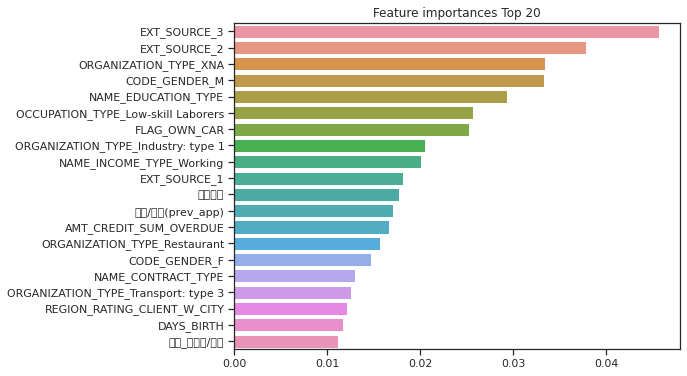

In [70]:
ftr_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
# sort_values() 쉽게 하기 위해서 시리즈로 만들고, 
# 최고 중요도가 높은 20개 피처들만 추출
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set_theme(style="ticks",
              font="AppleGothic", 
              rc={"axes.unicode_minus":False}
             )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
# x축은 중요도 값, y축은 ftr_top20 시리즈의 index
sns.barplot(x=ftr_top20 , y = ftr_top20.index)

plt.show()

In [46]:
# best["n_estimators"] = 500
# best["tree_method"] = "gpu_hist"
# print("=" * 20, "best  Parameters", "=" * 20)
# print(best)
# print("=" * 58)
# xgb = XGBClassifier(**best,
#                     use_label_encoder=False
#                    )
# xgb.fit(X_train, y_train,
#         eval_metric="auc", 
#         early_stopping_rounds=100,
#         eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
#         verbose=100
#        )

# print("=" * 20, "Model Parameters", "=" * 20)
# print(xgb.get_params())
# print("=" * 58)

# pred = xgb.predict(X_test)
# pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
# print("train best     score:", format(xgb.best_score, ".4f"))
# print("train best iteration:", format(xgb.best_iteration, ".3f"))
# print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
# print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
# get_clf_eval(y_test, pred, pred_p)
# print("=" * 58)

==================== best  Parameters ====================
{'base_score': 0.6000000000000001, 'booster': 'gbtree', 'colsample_bytree': 0.8, 'learning_rate': 0.15, 'n_estimators': 500, 'objective': 'binary:logistic', 'reg_alpha': 100, 'reg_lambda': 5, 'scale_pos_weight': 8.0, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
[0]	validation_0-auc:0.68510	validation_1-auc:0.68569	validation_2-auc:0.68333
[100]	validation_0-auc:0.80134	validation_1-auc:0.80156	validation_2-auc:0.80068
[200]	validation_0-auc:0.82663	validation_1-auc:0.82632	validation_2-auc:0.82758
[300]	validation_0-auc:0.84638	validation_1-auc:0.84589	validation_2-auc:0.84784
[400]	validation_0-auc:0.86271	validation_1-auc:0.86223	validation_2-auc:0.86412
[499]	validation_0-auc:0.87600	validation_1-auc:0.87557	validation_2-auc:0.87729
==================== Model Parameters ====================
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.6000000000000001, 'booster': 'gbtree', 'colsample_bylevel':

## 2차 조정

In [4]:
# regularization candiate 정의
reg_candidate = [0, 0.1, 3, 5, 7, 10, 20, 40, 60, 80, 90, 100, 110]
object_f = ["binary:logitraw", "binary:logistic"]
booster_c = ["gbtree"]


space = {"n_estimators":hopt.hp.choice("n_estimators", [3000]),
         "objective": hopt.hp.choice("objective", object_f),
         "learning_rate": hopt.hp.quniform("learning_rate", 0.01, 0.2, 0.01),
         "colsample_bytree": hopt.hp.quniform("colsample_bytree", 0.7, 1, 0.05),
         "subsample": hopt.hp.quniform("subsample", 0.7, 1, 0.05),
         "reg_lambda": hopt.hp.choice("reg_lambda", reg_candidate),
         "reg_alpha": hopt.hp.choice("reg_alpha", reg_candidate),
         "scale_pos_weight": hopt.hp.quniform("scale_pos_weight", 5, 12, 1),
         "base_score": hopt.hp.quniform("base_score", 0.5, 0.8, 0.1),
         "booster": hopt.hp.choice("booster", booster_c)
        }

def hyper_param_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          objective=space["objective"],
                          learning_rate=float(space["learning_rate"]),
#                           max_depth=int(space["max_depth"]), 
#                           min_child_weight=int(space["min_child_weight"]),
                          colsample_bytree=float(space["colsample_bytree"]),
                          subsample=float(space["subsample"]),
                          reg_lambda=float(space["reg_lambda"]),
                          reg_alpha=float(space["reg_alpha"]),
                          scale_pos_weight=space["scale_pos_weight"],
                          base_score=float(space["base_score"]),
                          tree_method="gpu_hist",
                          booster=space["booster"]
                         )

    model.fit(X_train, y_train,
            eval_metric="auc", 
            early_stopping_rounds=50,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=500
            )
    
    print("="*50)
    print(model)
    pred = model.predict(X_test)
    pred_p = pd.DataFrame(model.predict_proba(X_test))[1]
    print("train best     score:", format(model.best_score, ".4f"))
    print("test   roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
    print(hopt.STATUS_OK)
    print("="*50)

    score = roc_auc_score(y_test, pred)
    
    return {"loss": 1 - score,
            "status": STATUS_OK,
            "model": model
           }

trials = hopt.Trials()

best = hopt.fmin(fn=hyper_param_tuning,
                 space=space,
                 algo=hopt.tpe.suggest,
                 max_evals=50,
                 trials=trials
                )

# best["n_estimators"] = int(best["n_estimators"])
best["learning_rate"] = float(best["learning_rate"])
# best["max_depth"] = int(best["max_depth"])
# best["min_child_weight"] = int(best["min_child_weight"])
best["colsample_bytree"] = float(best["colsample_bytree"])
best["subsample"] = float(best["subsample"])
best["reg_lambda"] = reg_candidate[int(best["reg_lambda"])]
best["reg_alpha"] = reg_candidate[int(best["reg_alpha"])]
best["base_score"] = float(best["base_score"])
best["objective"] = object_f[int(best["objective"])]
best["booster"] = booster_c[int(best["booster"])]

best["n_estimators"] = 3000
best["tree_method"] = "gpu_hist"
print("=" * 20, "best  Parameters", "=" * 20)
print(best)
print("=" * 58)
xgb = XGBClassifier(**best,
                    use_label_encoder=False
                   )
xgb.fit(X_train, y_train,
        eval_metric="auc", 
        early_stopping_rounds=100,
        eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
        verbose=500
       )

print("=" * 20, "Model Parameters", "=" * 20)
print(xgb.get_params())
print("=" * 58)

pred = xgb.predict(X_test)
pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
print("train best     score:", format(xgb.best_score, ".4f"))
print("train best iteration:", format(xgb.best_iteration, ".3f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)
print("=" * 58)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66174	validation_1-auc:0.65318 
[152]	validation_0-auc:0.84313	validation_1-auc:0.76458
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.17, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=20.0, reg_lambda=40.0, scale_pos_weight=11.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                 
0.7653                                                
test   roc_auc_score:                                 
0.7653                                                
ok   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68812	validation_1-auc:0.68039                          
[458]	validation_0-auc:0.84208	validation_1-auc:0.76904                        
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                 
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=0.1, reg_lambda=60.0, scale_pos_weight=7.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                          
0.7692                                                                         
te

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69267	validation_1-auc:0.68199                          
[242]	validation_0-auc:0.83359	validation_1-auc:0.76683                        
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,           
              colsample_bynode=1, colsample_bytree=0.8500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.13, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=110.0, reg_lambda=0.1, scale_pos_weight=11.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                          
0.7675                                                                         
test   roc_auc_score:             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69042	validation_1-auc:0.68344                           
[160]	validation_0-auc:0.82849	validation_1-auc:0.76729                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.14, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=60.0, reg_lambda=7.0, scale_pos_weight=8.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7673                                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69336	validation_1-auc:0.68275                           
[191]	validation_0-auc:0.85083	validation_1-auc:0.76526                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=7.0,
              reg_lambda=7.0, scale_pos_weight=6.0,
              subsample=0.7000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7656                                                                          
test   roc_a

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65417	validation_1-auc:0.64735                           
[500]	validation_0-auc:0.81021	validation_1-auc:0.76904                         
[797]	validation_0-auc:0.82826	validation_1-auc:0.76987                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=60.0,
              reg_lambda=5.0, scale_pos_weight=7.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72059	validation_1-auc:0.71304                           
[403]	validation_0-auc:0.84421	validation_1-auc:0.76829                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.9500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=3.0, reg_lambda=0.0, scale_pos_weight=9.0,
              subsample=0.75, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7686                                                                          
test   roc_auc_score:                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71940	validation_1-auc:0.71012                           
[423]	validation_0-auc:0.85598	validation_1-auc:0.76919                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=10.0,
              reg_lambda=0.1, scale_pos_weight=9.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7696                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72020	validation_1-auc:0.71237                           
[263]	validation_0-auc:0.86748	validation_1-auc:0.76482                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.0,
              reg_lambda=0.0, scale_pos_weight=5.0, subsample=0.75,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7656                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.67870	validation_1-auc:0.67488                           
[378]	validation_0-auc:0.82020	validation_1-auc:0.76848                         
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=80.0, reg_lambda=5.0, scale_pos_weight=7.0,
              subsample=0.75, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7686                                                                          
test   roc_auc_score:                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68119	validation_1-auc:0.67541                            
[300]	validation_0-auc:0.82256	validation_1-auc:0.76837                          
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=60.0, scale_pos_weight=11.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7687                                                                           
test   roc_auc_score:                

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69620	validation_1-auc:0.68515                            
[500]	validation_0-auc:0.84636	validation_1-auc:0.76878                          
[533]	validation_0-auc:0.84974	validation_1-auc:0.76868                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.04, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=7.0,
              reg_lambda=7.0, scale_pos_weight=8.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7688

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69059	validation_1-auc:0.68731                            
[182]	validation_0-auc:0.83424	validation_1-auc:0.76407                          
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=80.0, scale_pos_weight=8.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7654                                                                           
test   roc_auc_score:                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69621	validation_1-auc:0.68204                            
[118]	validation_0-auc:0.84951	validation_1-auc:0.76183                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.19, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=7.0, reg_lambda=7.0, scale_pos_weight=9.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7632                                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72045	validation_1-auc:0.71325                            
[142]	validation_0-auc:0.85449	validation_1-auc:0.76223                          
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.9500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.16, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=0.1, scale_pos_weight=11.0,
              subsample=0.75, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7645                                                                           
test   roc_auc_score:                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69343	validation_1-auc:0.68367                            
[242]	validation_0-auc:0.85353	validation_1-auc:0.76629                          
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=100.0, scale_pos_weight=6.0,
              subsample=0.75, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7672                                                                           
test   roc_auc_score:                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69182	validation_1-auc:0.68377                            
[500]	validation_0-auc:0.83285	validation_1-auc:0.76936                          
[522]	validation_0-auc:0.83501	validation_1-auc:0.76927                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=40.0,
              reg_lambda=7.0, scale_pos_weight=9.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.64915	validation_1-auc:0.64388                            
[167]	validation_0-auc:0.82245	validation_1-auc:0.76510                          
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.7000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.19, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=110.0,
              reg_lambda=60.0, scale_pos_weight=10.0,
              subsample=0.7000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7662                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68111	validation_1-auc:0.67534                            
[414]	validation_0-auc:0.82439	validation_1-auc:0.76840                          
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=90.0, reg_lambda=40.0, scale_pos_weight=6.0,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7686                                                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69850	validation_1-auc:0.69633                            
[500]	validation_0-auc:0.80203	validation_1-auc:0.76724                          
[1000]	validation_0-auc:0.82684	validation_1-auc:0.76983                         
[1027]	validation_0-auc:0.82811	validation_1-auc:0.76989                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=20.0,
              reg_lambda=100.0, scale_pos_weight=6.0, subsample=0.75,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69223	validation_1-auc:0.68247                            
[256]	validation_0-auc:0.82350	validation_1-auc:0.76787                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=110.0,
              reg_lambda=90.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7679                                                                           
test   roc_auc_score:            

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69223	validation_1-auc:0.68247                            
[243]	validation_0-auc:0.82577	validation_1-auc:0.76796                          
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.11, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=110.0,
              reg_lambda=90.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7682                                                                           
test   roc_auc_score:           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69223	validation_1-auc:0.68247                           
[257]	validation_0-auc:0.82366	validation_1-auc:0.76787                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=110.0,
              reg_lambda=90.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7679                                                                          
test   roc_auc_score:                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69708	validation_1-auc:0.68336                           
[230]	validation_0-auc:0.84100	validation_1-auc:0.76622                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.11, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=5.0,
              reg_lambda=90.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7663                                                                          
test   roc_auc_score:                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69708	validation_1-auc:0.68336                           
[285]	validation_0-auc:0.85740	validation_1-auc:0.76611                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=5.0,
              reg_lambda=90.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7667                                                                          
test   roc_auc_score:                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69560	validation_1-auc:0.68205                           
[215]	validation_0-auc:0.85252	validation_1-auc:0.76626                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.11, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=5.0,
              reg_lambda=20.0, scale_pos_weight=10.0, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7671                                                                          
test   roc_auc_score:                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72193	validation_1-auc:0.71283                           
[269]	validation_0-auc:0.85775	validation_1-auc:0.76584                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=3.0, scale_pos_weight=10.0,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7669                                                                          
test   roc_auc_score:                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71881	validation_1-auc:0.70936                           
[209]	validation_0-auc:0.83681	validation_1-auc:0.76630                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.11, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=110.0, scale_pos_weight=12.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7669                                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69520	validation_1-auc:0.68361                           
[171]	validation_0-auc:0.83049	validation_1-auc:0.76651                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.17, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=90.0, reg_lambda=90.0, scale_pos_weight=11.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7670                                                                          
test   roc_auc_score:                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68989	validation_1-auc:0.68155                           
[217]	validation_0-auc:0.83442	validation_1-auc:0.76679                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.14, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=80.0,
              reg_lambda=90.0, scale_pos_weight=10.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7671                                                                          
test   ro

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71976	validation_1-auc:0.71347                           
[129]	validation_0-auc:0.85096	validation_1-auc:0.76206                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.17, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=10.0, scale_pos_weight=12.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7637                                                                          
test   roc

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69446	validation_1-auc:0.68107                           
[211]	validation_0-auc:0.84804	validation_1-auc:0.76645                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.13, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.0, reg_lambda=90.0, scale_pos_weight=11.0,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7675                                                                          
test   roc_auc_score:                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69451	validation_1-auc:0.68351                           
[300]	validation_0-auc:0.84121	validation_1-auc:0.76820                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=40.0,
              reg_lambda=80.0, scale_pos_weight=12.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7684                                                                          
test   ro

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69655	validation_1-auc:0.68108                           
[157]	validation_0-auc:0.84848	validation_1-auc:0.76510                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.13, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=3.0, reg_lambda=3.0, scale_pos_weight=11.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7657                                                                          
test   roc_auc_score:                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69505	validation_1-auc:0.68181                           
[156]	validation_0-auc:0.84317	validation_1-auc:0.76604                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=20.0,
              reg_lambda=20.0, scale_pos_weight=10.0, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7664                                                                          
test   roc_auc_score:                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71444	validation_1-auc:0.70721                           
[252]	validation_0-auc:0.82939	validation_1-auc:0.76768                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=110.0, reg_lambda=110.0, scale_pos_weight=11.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7683                                                                          
test   roc_auc_score:                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71785	validation_1-auc:0.71025                           
[340]	validation_0-auc:0.83656	validation_1-auc:0.76783                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=60.0,
              reg_lambda=10.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7682                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69452	validation_1-auc:0.68651                           
[310]	validation_0-auc:0.85112	validation_1-auc:0.76809                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=40.0, scale_pos_weight=5.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7682                                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68750	validation_1-auc:0.68063                           
[411]	validation_0-auc:0.84112	validation_1-auc:0.76900                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=5.0,
              reg_lambda=90.0, scale_pos_weight=7.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7691                                                                          
test   roc_auc_score:           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72079	validation_1-auc:0.71454                           
[133]	validation_0-auc:0.84700	validation_1-auc:0.76387                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=3.0, reg_lambda=5.0, scale_pos_weight=11.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7645                                                                          
test   roc_

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69137	validation_1-auc:0.68469                           
[166]	validation_0-auc:0.81594	validation_1-auc:0.76761                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.14, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=110.0, reg_lambda=90.0, scale_pos_weight=10.0,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7677                                                                          
test   roc_auc_score:                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69617	validation_1-auc:0.68429                           
[163]	validation_0-auc:0.84958	validation_1-auc:0.76445                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=9.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7647                                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71187	validation_1-auc:0.70678                           
[500]	validation_0-auc:0.78000	validation_1-auc:0.76016                         
[1000]	validation_0-auc:0.79555	validation_1-auc:0.76661                        
[1500]	validation_0-auc:0.80646	validation_1-auc:0.76870                        
[1931]	validation_0-auc:0.81478	validation_1-auc:0.76931                        
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=100.0, reg_lambda=0.1, scale_pos_weight=8.0,
              subsamp

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69575	validation_1-auc:0.68354                           
[343]	validation_0-auc:0.83811	validation_1-auc:0.76844                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=60.0,
              reg_lambda=60.0, scale_pos_weight=12.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7689                                                                          
test   roc_auc_score:                 

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72069	validation_1-auc:0.71337                           
[127]	validation_0-auc:0.85349	validation_1-auc:0.76389                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=7.0, reg_lambda=5.0, scale_pos_weight=11.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7647                                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68773	validation_1-auc:0.68054                           
[267]	validation_0-auc:0.82758	validation_1-auc:0.76868                         
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=80.0, reg_lambda=80.0, scale_pos_weight=10.0,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7692                                                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69529	validation_1-auc:0.68176                           
[355]	validation_0-auc:0.85669	validation_1-auc:0.76702                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=0.0, scale_pos_weight=9.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                           
0.7678                                                                          
test   roc_auc_score:                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71700	validation_1-auc:0.70871                           
[265]	validation_0-auc:0.84392	validation_1-auc:0.76730                         
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                  
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9500000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.11, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=40.0, reg_lambda=100.0, scale_pos_weight=12.0,
              subsample=0.7000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7685                                                                    

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69217	validation_1-auc:0.68474                           
[168]	validation_0-auc:0.83944	validation_1-auc:0.76673                         
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=0.8500000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.13, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=10.0,
              reg_lambda=40.0, scale_pos_weight=8.0,
              subsample=0.9500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7670                                                              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.72013	validation_1-auc:0.71157                           
[182]	validation_0-auc:0.84805	validation_1-auc:0.76633                         
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,            
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.16, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=20.0, reg_lambda=90.0, scale_pos_weight=11.0,
              subsample=0.8500000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7670                                                                          
test   roc_auc_score:                       

# NON SCALING LOG TRANSFORMATION
---


In [47]:
# load
train_datasets = pd.read_csv("../pre_data/[no_up]train_datasets.csv",
                             index_col=0)

# Label 만들기
train_target_ds = train_datasets["TARGET"]
train_target_ds = train_target_ds.astype("int32")

# TARGET feature 삭제
train_datasets.drop(columns="TARGET", inplace=True)

X_train , X_test , y_train , y_test = \
    train_test_split(train_datasets, 
                     train_target_ds, 
                     test_size=0.2, 
                     random_state=2021,
                     stratify=train_target_ds
                    )

# Valid
X_train_v, X_valid, y_train_v, y_valid = \
    train_test_split(X_train, 
                     y_train, 
                     test_size=0.25, 
                     random_state=2021,
                     stratify=y_train
                    )



In [48]:
# 기본 모델
xgb_c_b = XGBClassifier(n_estimators=1000,
                        use_label_encoder=False,
                        tree_method="gpu_hist",
                       )

xgb_c_b.fit(X_train_v, y_train_v,
            eval_metric="auc", 
            early_stopping_rounds=300,
            eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
            verbose=100
           )
pred = xgb_c_b.predict(X_test)
pred_p = pd.DataFrame(xgb_c_b.predict_proba(X_test))[1]
print("train best     score:", format(xgb_c_b.best_score, ".4f"))
print("train best iteration:", format(xgb_c_b.best_iteration, ".3f"))
# print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)

[0]	validation_0-auc:0.71462	validation_1-auc:0.71729	validation_2-auc:0.70658
[100]	validation_0-auc:0.84765	validation_1-auc:0.87878	validation_2-auc:0.75356
[200]	validation_0-auc:0.88559	validation_1-auc:0.93107	validation_2-auc:0.74591
[300]	validation_0-auc:0.90908	validation_1-auc:0.96263	validation_2-auc:0.74059
[347]	validation_0-auc:0.91617	validation_1-auc:0.97211	validation_2-auc:0.73815
train best     score: 0.7565
train best iteration: 48.000
@test  roc_auc_score: 0.7574
오차 행렬
[[55705   171]
 [ 4735   158]]
정확도 : 0.9193, 정밀도: 0.4802, 재현율 : 0.0323,    F1 : 0.0605, AUC:0.7574


In [50]:
# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
object_f = ["binary:logitraw", "reg:logistic", "binary:logistic"]
booster_c = ["gbtree", "gblinear", "dart"]


space = {"n_estimators":hopt.hp.choice("n_estimators", [50]),
         "objective": hopt.hp.choice("objective", object_f),
         "learning_rate": hopt.hp.quniform("learning_rate", 0.01, 0.2, 0.03),
#          "max_depth": hopt.hp.choice("max_depth", [-1]),
#          "min_child_weight": hopt.hp.quniform("min_child_weight", 5, 21, 4),
         "colsample_bytree": hopt.hp.quniform("colsample_bytree", 0.2, 1, 0.2),
         "subsample": hopt.hp.quniform("subsample", 0.2, 1, 0.2),
         "reg_lambda": hopt.hp.choice("reg_lambda", reg_candidate),
         "reg_alpha": hopt.hp.choice("reg_alpha", reg_candidate),
         "scale_pos_weight": hopt.hp.quniform("scale_pos_weight", 1, 9, 2),
         "base_score": hopt.hp.quniform("base_score", 0.5, 0.8, 0.1),
         "booster": hopt.hp.choice("booster", booster_c)
        }

def hyper_param_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          objective=space["objective"],
                          learning_rate=float(space["learning_rate"]),
#                           max_depth=int(space["max_depth"]), 
#                           min_child_weight=int(space["min_child_weight"]),
                          colsample_bytree=float(space["colsample_bytree"]),
                          subsample=float(space["subsample"]),
                          reg_lambda=float(space["reg_lambda"]),
                          reg_alpha=float(space["reg_alpha"]),
                          scale_pos_weight=space["scale_pos_weight"],
                          base_score=float(space["base_score"]),
                          tree_method="gpu_hist",
                          booster=space["booster"]
                         )

    model.fit(X_train, y_train,
            eval_metric="auc", 
            early_stopping_rounds=50,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=50, # 10개 단위로 출력
            )
    
    print("="*50)
    print(model)
    pred = model.predict(X_test)
    pred_p = pd.DataFrame(model.predict_proba(X_test))[1]
    print("train best     score:", format(model.best_score, ".4f"))
    print("test   roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
    print(hopt.STATUS_OK)
    print("="*50)

    score = roc_auc_score(y_test, pred)
    
    return {"loss": 1 - score,
            "status": STATUS_OK,
            "model": model
           }

trials = hopt.Trials()

best = hopt.fmin(fn=hyper_param_tuning,
                 space=space,
                 algo=hopt.tpe.suggest,
                 max_evals=50,
                 trials=trials
                )

# best["n_estimators"] = int(best["n_estimators"])
best["learning_rate"] = float(best["learning_rate"])
# best["max_depth"] = int(best["max_depth"])
# best["min_child_weight"] = int(best["min_child_weight"])
best["colsample_bytree"] = float(best["colsample_bytree"])
best["subsample"] = float(best["subsample"])
best["reg_lambda"] = reg_candidate[int(best["reg_lambda"])]
best["reg_alpha"] = reg_candidate[int(best["reg_alpha"])]
best["base_score"] = float(best["base_score"])
best["objective"] = object_f[int(best["objective"])]
best["booster"] = booster_c[int(best["booster"])]

best["n_estimators"] = 500
best["tree_method"] = "gpu_hist"
print("=" * 20, "best  Parameters", "=" * 20)
print(best)
print("=" * 58)
xgb = XGBClassifier(**best,
                    use_label_encoder=False
                   )
xgb.fit(X_train, y_train,
        eval_metric="auc", 
        early_stopping_rounds=100,
        eval_set=[(X_train, y_train),(X_train_v, y_train_v), (X_valid, y_valid)],
        verbose=100
       )

print("=" * 20, "Model Parameters", "=" * 20)
print(xgb.get_params())
print("=" * 58)

pred = xgb.predict(X_test)
pred_p = pd.DataFrame(xgb.predict_proba(X_test))[1]
print("train best     score:", format(xgb.best_score, ".4f"))
print("train best iteration:", format(xgb.best_iteration, ".3f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred), ".4f"))
print("@test  roc_auc_score:", format(roc_auc_score(y_test, pred_p), ".4f"))
get_clf_eval(y_test, pred, pred_p)
print("=" * 58)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:50:42] WARNING: ../src/learner.cc:573:            
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56046	validation_1-auc:0.56040 
[49]	validation_0-auc:0.61223	validation_1-auc:0.60867
XGBClassifier(base_score=0.8, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6000000000000001,
              gamma=None, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.18,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=50, n_jobs=4,
              num_parallel_tree=None, objective='binary:logitraw',
              rand

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66095	validation_1-auc:0.64903                           
[49]	validation_0-auc:0.80133	validation_1-auc:0.76169                          
XGBClassifier(base_score=0.6000000000000001, booster='dart',                    
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.0001,
              reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                           
0.7618                               

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62431	validation_1-auc:0.61277                            
[49]	validation_0-auc:0.79732	validation_1-auc:0.76244                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=1.0,
              reg_lambda=10.0, scale_pos_weight=4.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7624                                                                           
test   roc_auc_score:           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:51:21] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.59882	validation_1-auc:0.59795                            
[49]	validation_0-auc:0.69853	validation_1-auc:0.69454                           
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.67997	validation_1-auc:0.67327                            
[49]	validation_0-auc:0.77453	validation_1-auc:0.75431                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=5.0,
              reg_lambda=0.0001, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7543                                                                           
test   roc_auc_score:         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:52:01] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57182	validation_1-auc:0.57110                            
[49]	validation_0-auc:0.65855	validation_1-auc:0.65328                           
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=0.2, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.12, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71873	validation_1-auc:0.70915                            
[49]	validation_0-auc:0.80478	validation_1-auc:0.76061                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=1.0,
              reg_lambda=0.001, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7606                                                                           
test   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66238	validation_1-auc:0.64871                            
[49]	validation_0-auc:0.79742	validation_1-auc:0.76211                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=0.01, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7621                                                                       

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:52:45] WARNING: ../src/learner.cc:573:                                      
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.58176	validation_1-auc:0.58486                           
[49]	validation_0-auc:0.73389	validation_1-auc:0.73484                          
XGBClassifier(base_score=0.7000000000000001, booster='gblinear',                
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.18, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_es

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:53:06] WARNING: ../src/learner.cc:573:                                      
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.56031	validation_1-auc:0.56002                           
[49]	validation_0-auc:0.62142	validation_1-auc:0.61725                          
XGBClassifier(base_score=0.6000000000000001, booster='gblinear',                
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:53:26] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54865	validation_1-auc:0.54871                            
[49]	validation_0-auc:0.57324	validation_1-auc:0.57214                           
XGBClassifier(base_score=0.7000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.12, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68306	validation_1-auc:0.67849                            
[49]	validation_0-auc:0.79259	validation_1-auc:0.76125                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=10.0, reg_lambda=0.01, scale_pos_weight=2.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7612                                                                        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66110	validation_1-auc:0.64855                            
[49]	validation_0-auc:0.79574	validation_1-auc:0.76061                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=0.001, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7606                           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65343	validation_1-auc:0.64822                            
[49]	validation_0-auc:0.78094	validation_1-auc:0.75647                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=1.0,
              reg_lambda=1.0, scale_pos_weight=6.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7565                                                                           
test   roc_auc_

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:54:08] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.55395	validation_1-auc:0.55379                            
[49]	validation_0-auc:0.57719	validation_1-auc:0.57474                           
XGBClassifier(base_score=0.7000000000000001, booster='gblinear',                 
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2, gamma=None, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68115	validation_1-auc:0.67478                            
[49]	validation_0-auc:0.78532	validation_1-auc:0.75606                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.0001,
              reg_lambda=10.0, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7561                                                                           
test   roc_auc_score:        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66310	validation_1-auc:0.65172                            
[49]	validation_0-auc:0.81199	validation_1-auc:0.75876                           
XGBClassifier(base_score=0.6000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=0.001, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7593                           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.63850	validation_1-auc:0.63759                            
[49]	validation_0-auc:0.77392	validation_1-auc:0.75689                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.01,
              reg_lambda=5.0, scale_pos_weight=2.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7569                                                                           
test   roc_auc_score:                

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.61020	validation_1-auc:0.61373                            
[49]	validation_0-auc:0.74386	validation_1-auc:0.73859                           
XGBClassifier(base_score=0.7000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=100.0, scale_pos_weight=2.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7386                                                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66307	validation_1-auc:0.65198                            
[49]	validation_0-auc:0.79775	validation_1-auc:0.76207                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=5.0,
              reg_lambda=0.001, scale_pos_weight=8.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7621                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66209	validation_1-auc:0.64797                            
[49]	validation_0-auc:0.77893	validation_1-auc:0.75616                           
XGBClassifier(base_score=0.6000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.06, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=1e-05, reg_lambda=0.1, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7562                                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66190	validation_1-auc:0.64918                            
[49]	validation_0-auc:0.77730	validation_1-auc:0.75542                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=5.0, reg_lambda=0.1, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7554                                                                           
test   roc_auc_score:                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.50000	validation_1-auc:0.50000                            
[49]	validation_0-auc:0.50000	validation_1-auc:0.50000                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=100.0,
              reg_lambda=1.0, scale_pos_weight=8.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.5000                                                                           
test   roc_auc_score:           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71073	validation_1-auc:0.70511                            
[49]	validation_0-auc:0.78974	validation_1-auc:0.76096                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=6.0,
              subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7610                                                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62635	validation_1-auc:0.61057                            
[49]	validation_0-auc:0.79827	validation_1-auc:0.76206                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=0.0001, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7621                                                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65182	validation_1-auc:0.64358                            
[49]	validation_0-auc:0.76682	validation_1-auc:0.75113                           
XGBClassifier(base_score=0.6000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.001,
              reg_lambda=0.001, scale_pos_weight=6.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7511                                                                           
test   roc_auc_score:             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68206	validation_1-auc:0.67787                            
[49]	validation_0-auc:0.79106	validation_1-auc:0.76311                           
XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=100.0,
              reg_lambda=0.01, scale_pos_weight=8.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7631                                                                           
test   roc_auc_score:      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62615	validation_1-auc:0.60994                            
[49]	validation_0-auc:0.78395	validation_1-auc:0.75977                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=5.0,
              reg_lambda=0.001, scale_pos_weight=6.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7598                                                                           
test   roc_auc_score:          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.65270	validation_1-auc:0.64232                            
[49]	validation_0-auc:0.80058	validation_1-auc:0.75701                           
XGBClassifier(base_score=0.7000000000000001, booster='dart',                     
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='binary:logitraw', random_state=0,
              reg_alpha=5.0, reg_lambda=0.01, scale_pos_weight=8.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7573                                                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66223	validation_1-auc:0.65078                            
[49]	validation_0-auc:0.81149	validation_1-auc:0.76190                           
XGBClassifier(base_score=0.8, booster='dart', colsample_bylevel=1,               
              colsample_bynode=1, colsample_bytree=0.6000000000000001, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=0.0001, scale_pos_weight=6.0, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7619                                                                           
test   roc_au

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66513	validation_1-auc:0.65203                            
[49]	validation_0-auc:0.80648	validation_1-auc:0.76248                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6000000000000001, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.1,
              reg_lambda=0.1, scale_pos_weight=8.0, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7625                                                           

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62628	validation_1-auc:0.61033                            
[49]	validation_0-auc:0.80781	validation_1-auc:0.76168                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7617                                                                           
test   roc_auc_score:                                      

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.66233	validation_1-auc:0.64870                            
[49]	validation_0-auc:0.80328	validation_1-auc:0.76174                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=8.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7617                                                                          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68988	validation_1-auc:0.68278                            
[49]	validation_0-auc:0.80146	validation_1-auc:0.76108                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0.1,
              reg_lambda=10.0, scale_pos_weight=8.0, subsample=0.4,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7612                                                                           
test   roc_auc_score:        

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.62569	validation_1-auc:0.61070                            
[49]	validation_0-auc:0.80228	validation_1-auc:0.76135                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.18, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=4.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7613                                                                          

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69588	validation_1-auc:0.67978                            
[49]	validation_0-auc:0.80705	validation_1-auc:0.76342                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=6.0,
              subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7634                                                                         

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71288	validation_1-auc:0.70629                            
[49]	validation_0-auc:0.78913	validation_1-auc:0.76352                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=8.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7635                                                                           
test   roc_auc_score:                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.70743	validation_1-auc:0.70212                            
[49]	validation_0-auc:0.78524	validation_1-auc:0.76268                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=8.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7627                                                                           
test   roc_auc_score:                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:57:39] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54177	validation_1-auc:0.54248                            
[49]	validation_0-auc:0.57268	validation_1-auc:0.57016                           
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=1.0, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.21, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69204	validation_1-auc:0.69036                            
[49]	validation_0-auc:0.77962	validation_1-auc:0.76161                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=4.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7616                                                                           
test   roc_auc_score:                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.70743	validation_1-auc:0.70212                            
[49]	validation_0-auc:0.78174	validation_1-auc:0.76058                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=8.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7607                                                                           
test   roc_auc_score:                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:58:05] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54380	validation_1-auc:0.54425                            
[49]	validation_0-auc:0.57642	validation_1-auc:0.57232                           
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=1.0, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.21, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69916	validation_1-auc:0.69489                            
[49]	validation_0-auc:0.78179	validation_1-auc:0.76016                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=100.0, reg_lambda=1e-05, scale_pos_weight=6.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7602                                                                           
test   roc_auc_score:                                  

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:58:27] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54998	validation_1-auc:0.55138                            
[49]	validation_0-auc:0.58703	validation_1-auc:0.58150                           
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=0.8, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.21, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.71348	validation_1-auc:0.70738                            
[49]	validation_0-auc:0.80524	validation_1-auc:0.75938                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=5.0, scale_pos_weight=8.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7594                                                                           
test   roc_auc_score:                                     

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.67941	validation_1-auc:0.67117                            
[49]	validation_0-auc:0.79178	validation_1-auc:0.74392                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.0001, reg_lambda=1.0, scale_pos_weight=8.0,
              subsample=0.2, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7456                                                                           
test   roc_auc_score:                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[12:58:50] WARNING: ../src/learner.cc:573:                                       
Parameters: { "colsample_bytree", "subsample", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.54181	validation_1-auc:0.54254                            
[49]	validation_0-auc:0.57268	validation_1-auc:0.57016                           
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,        
              colsample_bynode=None, colsample_bytree=1.0, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.21, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=4, num_paralle

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68759	validation_1-auc:0.68120                            
[49]	validation_0-auc:0.79999	validation_1-auc:0.76050                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.001, reg_lambda=10.0, scale_pos_weight=4.0,
              subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)
train best     score:                                                            
0.7606                                                                           
test   roc_auc_score:                                   

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.68956	validation_1-auc:0.68659                            
[49]	validation_0-auc:0.77381	validation_1-auc:0.75849                           
XGBClassifier(base_score=0.6000000000000001, booster='gbtree',                   
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.21, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=100.0,
              reg_lambda=100.0, scale_pos_weight=8.0, subsample=0.2,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7585                                                                           
test   roc_auc_score:             

/home/lab10/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[0]	validation_0-auc:0.69264	validation_1-auc:0.68172                            
[49]	validation_0-auc:0.80551	validation_1-auc:0.76106                           
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,             
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.0, reg_lambda=1e-05, scale_pos_weight=6.0,
              subsample=0.6000000000000001, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)
train best     score:                                                            
0.7612                                                                           
test   roc_auc_score:                    

---
---
---

In [59]:
# # 다중공선성 제거
# # https://john-analyst.medium.com/캐글-home-credit-default-risk-9225050b6fa6

# corrs = train_datasets.iloc[:, 1:].corr()

# above_feature = {}

# for corr in corrs:
#     above_feature[corr] = list(corrs.index[corrs[corr] > 0.8])

# for key in above_feature.keys():
#     if len(above_feature[key]) > 1:
#         print(above_feature[key])

# uf.corr_heatmap(train_datasets[['DAYS_EMPLOYED', 'Contact', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA']])

In [ ]:
# python에서 한글과 영어를 줄 맞춰서 예쁘게 출력하자.
# https://frhyme.github.io/python-libs/print_kor_and_en_full_half_width/

# import unicodedata

# def fill_str_with_space(input_s="", max_size=40, fill_char="*"):
#     """
#     - 길이가 긴 문자는 2칸으로 체크하고, 짧으면 1칸으로 체크함. 
#     - 최대 길이(max_size)는 40이며, input_s의 실제 길이가 이보다 짧으면 
#     남은 문자를 fill_char로 채운다.
#     """
#     l = 0 
#     for c in input_s:
#         if unicodedata.east_asian_width(c) in ['F', 'W']:
#             l+=2
#         else: 
#             l+=1
#     return input_s+fill_char*(max_size-l)


# a = "abc"
# b = "이승훈"

# print(fill_str_with_space("abc", max_size=40))
# print(fill_str_with_space("이승훈", max_size=40))

#####################
# len("".encode('utf-8'))